# 事前準備

In [1]:
# 各種ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
# MNISTデータ読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(X_train.shape)
print(X_test.shape)
print(X_train[0].dtype)

(60000, 28, 28)
(10000, 28, 28)
uint8


In [4]:
# 全てのピクセルを一列にするため、平滑化を行う
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [5]:
#前処理 画像は0~255で表されるが、機械学習をする上では0~1のfloat型で扱う
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.min(), "-", X_train.max())
print(X_test.min(), "-", X_test.max())

0.0 - 1.0
0.0 - 1.0


In [6]:
# 正解ラベル（0から9の整数）をone-hot表現に変換する
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.fit_transform(y_test[:, np.newaxis])
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

(60000,)
(60000, 10)
float64


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [8]:
class GetMiniBatch:
    """ミニバッチを取得するイテレータ
    :parameters
        X (2d-array, (n_samples, n_features)): 訓練データ
        y (1d-array, (n_samples, 1)): 正解値
        batch_size (int): バッチサイズ
        seed (int): 乱数のシード
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# 【問題1】全結合層のクラス化

全結合層のクラス化を行なってください。

In [9]:
class FC:
    """ノード数n_nodes1からn_nodes2への全結合層
    :parameters
        n_node1 (int): 前層のノード数
        n_node2 (int): 後層のノード数
        initializer (class instance): 初期化方法のインスタンス
        optimizer (class instance): 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 重みとバイアスの初期化
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes1, n_nodes2)  # Xavier Heではn_nodes1が必要
    
    def forward(self, X):
        """順伝播
        :parameters
            X (2d-array, (batch_size, n_nodes1)): 入力
        :returns
            A (2d-array, (batch_sizer, n_nodes2)): 出力
        """
        A = np.matmul(X, self.W) + self.B
        # backward用にXを保持
        self.X = X
        self.N = X.shape[0]  # Backward内のoptimizer.updateで、平均を計算するとき使用する
        return A
    
    def backward(self, dA):
        """逆伝播
        :parameters
            dA (2d-array, (batch_size, n_nodes2)): 後層から戻ってきた勾配
        :returns
            dZ (2d-array, (batch_size, n_nodes1)): 前層に送る勾配
        """
        self.dB = np.sum(dA, axis=0, keepdims=True)
        self.dW = np.matmul(self.X.T, dA)
        dX = np.matmul(dA, self.W.T)
        # 勾配をもとに重みとバイアスを更新
        self = self.optimizer.update(self)
        return dX

# 【問題2】初期化方法のクラス化

初期化を行うコードをクラス化してください。

In [10]:
class SimpleInitializer:
    """正規分布によるシンプルな初期化
    :parameters
        sigma (float): 正規分布の標準偏差
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """重みの初期化
        :parameters
            n_nodes1 (int): 前の層のノード数
            n_nodes2 (int): 後の層のノード数
        :returns
            W (2d-array, (n_nodes1, n_nodes2)): ランダムに発生させた重み
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes1, n_nodes2):
        """バイアスの初期化
        :parameters
            n_nodes2 (int): 後の層のノード数
        :returns
            B (1d-array, (n_nodes2, )): ランダムに発生させたバイアス
        """
        return self.sigma * np.random.randn(1, n_nodes2)

# 【問題3】最適化手法のクラス化

最適化手法のクラス化を行なってください。

In [11]:
class SGD:
    """確率的勾配降下法
    :parameters
        lr (float): 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, layer):
        """ある層の重みやバイアスを更新する
        :parameters
            layer (instance): 更新前の層（FC）のインスタンス
        """
        layer.W -= self.lr * layer.dW / layer.N
        layer.B -= self.lr * layer.dB / layer.N
        return layer

# 【問題4】活性化関数のクラス化

活性化関数のクラス化を行なってください。

In [12]:
class Tanh:
    """tanh関数（活性化関数）"""
    def forward(self, A):
        Z = np.tanh(A)
        # backward用にAを保持
        self.A = A
        return Z
    
    def backward(self, dZ):
        dA = dZ * (1 - np.tanh(self.A)**2)
        return dA

    
class Sigmoid:
    """sigmoid関数（活性化関数）"""
    def forward(self, A):
        Z = 1 / (1 + np.exp(-A))
        # backward用にZを保持
        self.Z = Z
        return Z
    
    def backward(self, dZ):
        dA = dZ * self.Z * (1 - self.Z)
        return dA

In [13]:
class Softmax:
    """softmax関数
    backwardは交差エントロピー誤差関数と合わせて計算する
    """
    def forward(self, A):
        Z = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
        # backward用にZを保持
        self.Z = Z
        return Z
    
    def backward(self, y):
        dA = self.Z - y
        return dA

# 【問題5】ReLUクラスの作成

現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。

In [14]:
class ReLU:
    """rectified linear unit関数（活性化関数）"""
    def forward(self, A):
        self.is_positive = A > 0
        Z = self.is_positive * A
        return Z
    
    def backward(self, dZ):
        dA = self.is_positive * dZ
        return dA

# 【問題6】重みの初期値

ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。    
しかし、どのような値にすると良いかが知られています。  
シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。  
XavierInitializerクラスと、HeInitializerクラスを作成してください。

In [15]:
class XavierInitializer:
    """Xavierの初期値"""
    def W(self, n_nodes1, n_nodes2):
        """重みの初期化
        :parameters
            n_nodes1 (int): 前の層のノード数
            n_nodes2 (int): 後の層のノード数
        :returns
            W (2d-array, (n_nodes1, n_nodes2)): ランダムに発生させた重み
        """
        return 1.0 / np.sqrt(n_nodes1) * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes1, n_nodes2):
        """バイアスの初期化
        :parameters
            n_nodes2 (int): 後の層のノード数
        :returns
            B (1d-array, (n_nodes2, )): ランダムに発生させたバイアス
        """
        return 1.0 / np.sqrt(n_nodes1) * np.random.randn(1, n_nodes2)

    
class HeInitializer:
    """Heの初期値"""
    def W(self, n_nodes1, n_nodes2):
        """重みの初期化
        :parameters
            n_nodes1 (int): 前の層のノード数
            n_nodes2 (int): 後の層のノード数
        :returns
            W (2d-array, (n_nodes1, n_nodes2)): ランダムに発生させた重み
        """
        return np.sqrt(2.0 / n_nodes1) * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes1, n_nodes2):
        """バイアスの初期化
        :parameters
            n_nodes2 (int): 後の層のノード数
        :returns
            B (1d-array, (n_nodes2, )): ランダムに発生させたバイアス
        """
        return np.sqrt(2.0 / n_nodes1) * np.random.randn(1, n_nodes2)

# 【問題7】最適化手法

学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。

In [16]:
class AdaGrad:
    """Adative Gradient法
    :parameters
        lr (float): 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        self.H_W = 0
        self.H_B = 0
    
    def update(self, layer):
        """ある層の重みやバイアスを更新する
        :parameters
            layer (instance): 更新前の層（FC）のインスタンス
        """
        # 行列Hを求める
        self.H_W += layer.dW * layer.dW
        self.H_B += layer.dB * layer.dB
        # 重み・バイアスの更新
        layer.W -= self.lr * layer.dW / (np.sqrt(self.H_W) + 1e-8) / layer.N
        layer.B -= self.lr * layer.dB / (np.sqrt(self.H_B) + 1e-8) / layer.N
        return layer

# 【問題8】クラスの完成

任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [17]:
class ScratchDeepNeuralNetworkClassifier():
    """ニューラルネットワーク分類器
    :attributes
        layers (list of instances): 各層のインスタンスを並べたリスト
        n_epoch (int): 繰り返すエポック数
        batch_size (int): ミニバッチのデータ数
        plot_interval (int): 損失関数を記録する間隔
        epoch_interval (int): 何epochごとにprintするか
        loss (list): 損失関数の推移（訓練データ）
        lossval (list): 損失関数の推移（検証データ）
        verbose (bool): 学習過程を出力する場合はTrue
    """
    def __init__(self, layers, n_epoch=10, batch_size=20, plot_interval=1, verbose=True, epoch_interval=1):
        self.layers = layers
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.plot_interval = plot_interval
        self.epoch_interval = epoch_interval
        self.verbose = verbose
        self.loss = []
        self.loss_val = []
    
    def fit(self, X, y, X_val=None, y_val=None):
        """ニューラルネットワーク分類器を学習する。
        :parameters
            X (2d-array, (n_samples, n_features)): 訓練データの特徴量
            y (2d-array, (n_samples, n_classes)): 訓練データの正解値（One-hot）
            X_val (2d-array, (n_samples, n_features)): 検証データの特徴量
            y_val (2d-array, (n_samples, n_classes)): 検証データの正解値（One-hot）
            optimizer (instance): 最適化手法のインスタンス
        """
        # データチェック
        self.n_features = X.shape[1]
        self.n_output = y.shape[1]

        # 学習
        for epoch in range(self.n_epoch):
            # エポックごとに乱数を変えて、ミニバッチを取得する
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=epoch)
            
            # ミニバッチごとに学習をすすめる。
            for mini_X_train, mini_y_train in get_mini_batch:
                # forward
                for i, layer in enumerate(self.layers):
                    pass_x = mini_X_train if i == 0 else value
                    value = layer.forward(pass_x)

                # backward
                for i, layer in enumerate(reversed(self.layers)):
                    pass_y = mini_y_train if i == 0 else grad
                    grad = layer.backward(pass_y)
                
            # 損失（交差エントロピー誤差）を計算して保持
            y_pred = self.predict_proba(X)  # 分類カテゴリーごとの確率を計算
            L = self.cross_entropy_error(y_pred, y)
            self.loss.append(L)
            # 検証データありの場合はそちらの損失も保持
            if X_val is not None and y_val is not None:
                y_pred_val = self.predict_proba(X_val)  # 分類カテゴリーごとの確率を計算
                L_val = self.cross_entropy_error(y_pred_val, y_val)
                self.loss_val.append(L_val)

            # 学習過程の出力（エポックごと）
            if self.verbose and (epoch % self.epoch_interval == 0):
                # 検証データがある場合
                if len(self.loss_val) != 0:
                    print("Epoch {}:   Loss={:.5f}   Loss_valid={:.5f}".format(epoch, self.loss[-1], self.loss_val[-1]))
                # 検証データがない場合
                else:
                    print("Epoch {}:   Loss={:.5f}".format(epoch, self.loss[-1]))

    def cross_entropy_error(self, y_pred, y_true):
        """交差エントロピー誤差の計算
        :parameters
            y_true (2d-array, (n_samples, n_classes)): クラスの正解ラベル（one-hotなので0 or 1）
            y_pred (2d-array, (n_samples, n_classes)): クラス分類の予測確率（yと同じ形状）
        :returns
            cee (float): 交差エントロピー誤差
        """
        cee = -1/y_pred.shape[0] * np.sum(y_true * np.log(y_pred))
        return cee
    
    def predict_proba(self, X):
        """ニューラルネットワーク分類器を使い推定する。推定結果は確率のOne-hot表現。
        :parameters
            X (2d-array, (n_samples, n_features)): サンプルデータ
        :returns
            value (2d-array, (n_samples, n_classes)): 推定確率
        """
        # forward
        for i, layer in enumerate(self.layers):
            pass_x = X if i == 0 else value
            value = layer.forward(pass_x)
        return value
    
    def predict(self, X):
        """ニューラルネットワーク分類器を使い推定する。
        :parameters
            X (2d-array, (n_samples, n_features)): サンプル
        :returns
            label (1d-array, (n_samples,)): 推定ラベル
        """
        probability = self.predict_proba(X)
        label = np.argmax(probability, axis=1)
        return label

# 【問題9】学習と推定

In [18]:
def calc_accuracy(nn):
    print("Validation Data")
    y_pred = nn.predict(X_val)
    y_true = np.argmax(y_val, axis=1)
    print(y_pred.shape)
    print(y_true.shape)
    acc = accuracy_score(y_true, y_pred)
    print("accuracy = {:.5f}".format(acc))

    print()
    print("Test Data")
    y_pred_test = nn.predict(X_test)
    y_true_test = y_test
    print(y_pred_test.shape)
    print(y_true_test.shape)
    acc_test = accuracy_score(y_true_test, y_pred_test)
    print("accuracy = {:.5f}".format(acc_test))

In [19]:
def draw_loss(nn):
    fig, ax = plt.subplots(figsize=(5, 5))
    x1 = np.arange(len(nn.loss))
    y1 = nn.loss
    x2 = np.arange(len(nn.loss_val))
    y2 = nn.loss_val

    ax.plot(x1, y1, label="train", alpha=0.7)
    ax.plot(x2, y2, label="valid", alpha=0.7)

    ax.set_xlabel("Epoch", fontsize=20)
    ax.set_ylabel("Loss Function Value", fontsize=20)
    ax.set_yscale("log")
    ax.set_xlim(-1, nn.n_epoch + 1)
    ax.set_ylim(1e-4, 5)
    ax.legend(frameon=False)
    plt.show()

Epoch 0:   Loss=0.68448   Loss_valid=0.66973
Epoch 2:   Loss=0.34337   Loss_valid=0.33586
Epoch 4:   Loss=0.27518   Loss_valid=0.27483
Epoch 6:   Loss=0.22630   Loss_valid=0.22817
Epoch 8:   Loss=0.18380   Loss_valid=0.18986
Epoch 10:   Loss=0.15447   Loss_valid=0.16277
Epoch 12:   Loss=0.13900   Loss_valid=0.15233
Epoch 14:   Loss=0.11546   Loss_valid=0.13254
Epoch 16:   Loss=0.09971   Loss_valid=0.12042
Epoch 18:   Loss=0.08780   Loss_valid=0.11178
Validation Data
(12000,)
(12000,)
accuracy = 0.96758

Test Data
(10000,)
(10000,)
accuracy = 0.96790


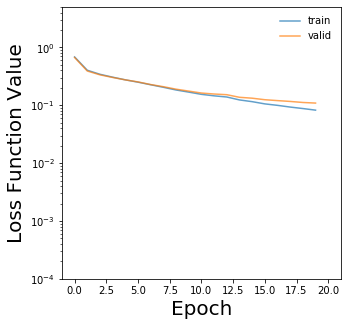

In [20]:
# 前回と同じ
layers = [
    FC(X_train.shape[1], 200, SimpleInitializer(), SGD()),
    Tanh(),
    FC(200, 400, SimpleInitializer(), SGD()),
    Tanh(),
    FC(400, y_train.shape[1], SimpleInitializer(), SGD()),
    Softmax(),
]

dnn = ScratchDeepNeuralNetworkClassifier(layers, n_epoch=20, epoch_interval=2)
dnn.fit(X_train, y_train, X_val, y_val)
calc_accuracy(dnn)
draw_loss(dnn)

Epoch 0:   Loss=0.43985   Loss_valid=0.43232
Epoch 2:   Loss=0.35036   Loss_valid=0.34212
Epoch 4:   Loss=0.32324   Loss_valid=0.31506
Epoch 6:   Loss=0.30834   Loss_valid=0.30059
Epoch 8:   Loss=0.29823   Loss_valid=0.29083
Epoch 10:   Loss=0.29064   Loss_valid=0.28362
Epoch 12:   Loss=0.28476   Loss_valid=0.27827
Epoch 14:   Loss=0.27959   Loss_valid=0.27344
Epoch 16:   Loss=0.27525   Loss_valid=0.26977
Epoch 18:   Loss=0.27134   Loss_valid=0.26625
Validation Data
(12000,)
(12000,)
accuracy = 0.92417

Test Data
(10000,)
(10000,)
accuracy = 0.92400


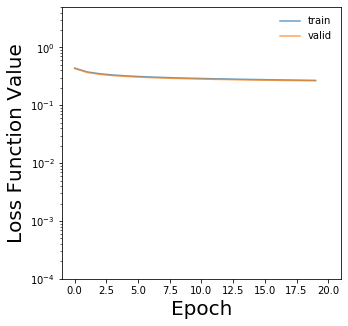

In [22]:
# AdaGradを使用
layers = [
    FC(X_train.shape[1], 200, XavierInitializer(), AdaGrad()),
    Tanh(),
    FC(200, 400, XavierInitializer(), AdaGrad()),
    Tanh(),
    FC(400, y_train.shape[1], XavierInitializer(), AdaGrad()),
    Softmax(),
]

dnn = ScratchDeepNeuralNetworkClassifier(layers, n_epoch=20, epoch_interval=2)
dnn.fit(X_train, y_train, X_val, y_val)
calc_accuracy(dnn)
draw_loss(dnn)